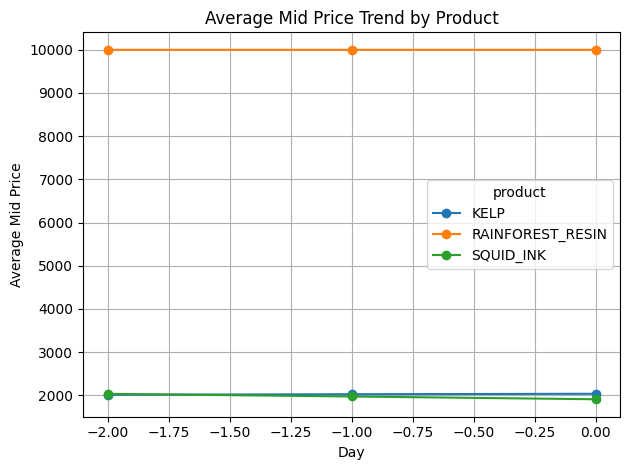

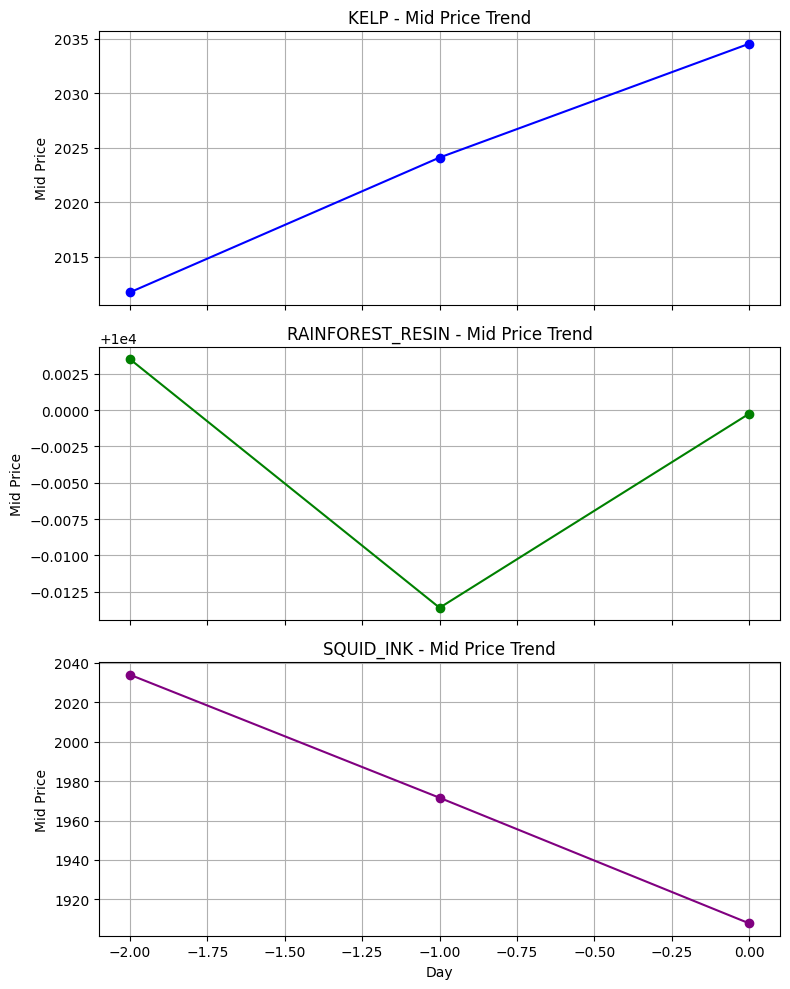

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load all the uploaded CSV files
prices_day_minus_2 = pd.read_csv("data/prices_round_1_day_-2.csv")
prices_day_minus_1 = pd.read_csv("data/prices_round_1_day_-1.csv")
prices_day_0 = pd.read_csv("data/prices_round_1_day_0.csv")

trades_day_minus_2 = pd.read_csv("data/trades_round_1_day_-2.csv")
trades_day_minus_1 = pd.read_csv("data/trades_round_1_day_-1.csv")
trades_day_0 = pd.read_csv("data/trades_round_1_day_0.csv")


# Convert the CSVs using proper delimiters since they are semicolon-separated
prices_day_minus_2 = pd.read_csv("data/prices_round_1_day_-2.csv", sep=";")
prices_day_minus_1 = pd.read_csv("data/prices_round_1_day_-1.csv", sep=";")
prices_day_0 = pd.read_csv("data/prices_round_1_day_0.csv", sep=";")

trades_day_minus_2 = pd.read_csv("data/trades_round_1_day_-2.csv", sep=";")
trades_day_minus_1 = pd.read_csv("data/trades_round_1_day_-1.csv", sep=";")
trades_day_0 = pd.read_csv("data/trades_round_1_day_0.csv", sep=";")

# Combine price data for trend analysis
prices_combined = pd.concat([
    prices_day_minus_2.assign(day=-2),
    prices_day_minus_1.assign(day=-1),
    prices_day_0.assign(day=0)
], ignore_index=True)

# Focus on mid_price trends by product
avg_mid_prices = prices_combined.groupby(["day", "product"])["mid_price"].mean().unstack()


avg_mid_prices.plot(marker='o', title="Average Mid Price Trend by Product")
plt.xlabel("Day")
plt.ylabel("Average Mid Price")
plt.grid(True)
plt.tight_layout()
plt.show()


# Extract mid price trend for each product separately
kelp_prices = prices_combined[prices_combined["product"] == "KELP"].groupby("day")["mid_price"].mean()
resin_prices = prices_combined[prices_combined["product"] == "RAINFOREST_RESIN"].groupby("day")["mid_price"].mean()
squid_prices = prices_combined[prices_combined["product"] == "SQUID_INK"].groupby("day")["mid_price"].mean()

# Plot individual trends
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

kelp_prices.plot(ax=axs[0], marker='o', color='blue', title="KELP - Mid Price Trend")
axs[0].set_ylabel("Mid Price")
axs[0].grid(True)

resin_prices.plot(ax=axs[1], marker='o', color='green', title="RAINFOREST_RESIN - Mid Price Trend")
axs[1].set_ylabel("Mid Price")
axs[1].grid(True)

squid_prices.plot(ax=axs[2], marker='o', color='purple', title="SQUID_INK - Mid Price Trend")
axs[2].set_xlabel("Day")
axs[2].set_ylabel("Mid Price")
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Kelp mid price analysis


KELP Mid-Price Analysis Techniques


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")


In [12]:
prices_day_0 = pd.read_csv("data/prices_round_1_day_-2.csv", sep=';')
prices_day_1 = pd.read_csv("data/prices_round_1_day_-1.csv", sep=';')
prices_day_2 = pd.read_csv("data/prices_round_1_day_0.csv", sep=';')

trades_day_0 = pd.read_csv("data/trades_round_1_day_-2.csv", sep=';')
trades_day_1 = pd.read_csv("data/trades_round_1_day_-1.csv", sep=';')
trades_day_2 = pd.read_csv("data/trades_round_1_day_0.csv", sep=';')

prices_combined = pd.concat([
    prices_day_0.assign(day=-2),
    prices_day_1.assign(day=-1),
    prices_day_2.assign(day=0)
], ignore_index=True)

# Examine sample of the data to understand structure
prices_combined.head()


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
4,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0


In [13]:
# 2. Basic Statistical Analysis
kelp_data = prices_combined[prices_combined["product"] == "KELP"].copy()

# Display basic information about the dataset
print("KELP dataset shape:", kelp_data.shape)
kelp_data.info()

KELP dataset shape: (30000, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 89999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day              30000 non-null  int64  
 1   timestamp        30000 non-null  int64  
 2   product          30000 non-null  object 
 3   bid_price_1      30000 non-null  int64  
 4   bid_volume_1     30000 non-null  int64  
 5   bid_price_2      6425 non-null   float64
 6   bid_volume_2     6425 non-null   float64
 7   bid_price_3      496 non-null    float64
 8   bid_volume_3     496 non-null    float64
 9   ask_price_1      30000 non-null  int64  
 10  ask_volume_1     30000 non-null  int64  
 11  ask_price_2      7722 non-null   float64
 12  ask_volume_2     7722 non-null   float64
 13  ask_price_3      663 non-null    float64
 14  ask_volume_3     663 non-null    float64
 15  mid_price        30000 non-null  float64
 16  profit_and_loss  30000 non-null

In [14]:
# Calculate basic descriptive statistics
kelp_stats = kelp_data['mid_price'].describe()
print("KELP Mid-Price Statistics:")
print(kelp_stats)

# Additional statistics
skewness = kelp_data['mid_price'].skew()
kurtosis = kelp_data['mid_price'].kurt()
print(f"\nSkewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

KELP Mid-Price Statistics:
count    30000.000000
mean      2023.476467
std         10.898111
min       1997.000000
25%       2014.500000
50%       2025.000000
75%       2033.500000
max       2044.500000
Name: mid_price, dtype: float64

Skewness: -0.5066
Kurtosis: -0.9185


In [15]:
# Calculate daily statistics
kelp_daily_stats = kelp_data.groupby("day")["mid_price"].agg(['mean', 'median', 'min', 'max', 'std', 'count'])
print("\nDaily KELP Mid-Price Statistics:")
print(kelp_daily_stats)


Daily KELP Mid-Price Statistics:
          mean  median     min     max       std  count
day                                                    
-2   2011.7620  2010.0  1997.0  2034.0  8.449535  10000
-1   2024.1158  2024.0  2011.0  2036.5  4.330770  10000
 0   2034.5516  2035.0  2024.5  2044.5  2.420315  10000


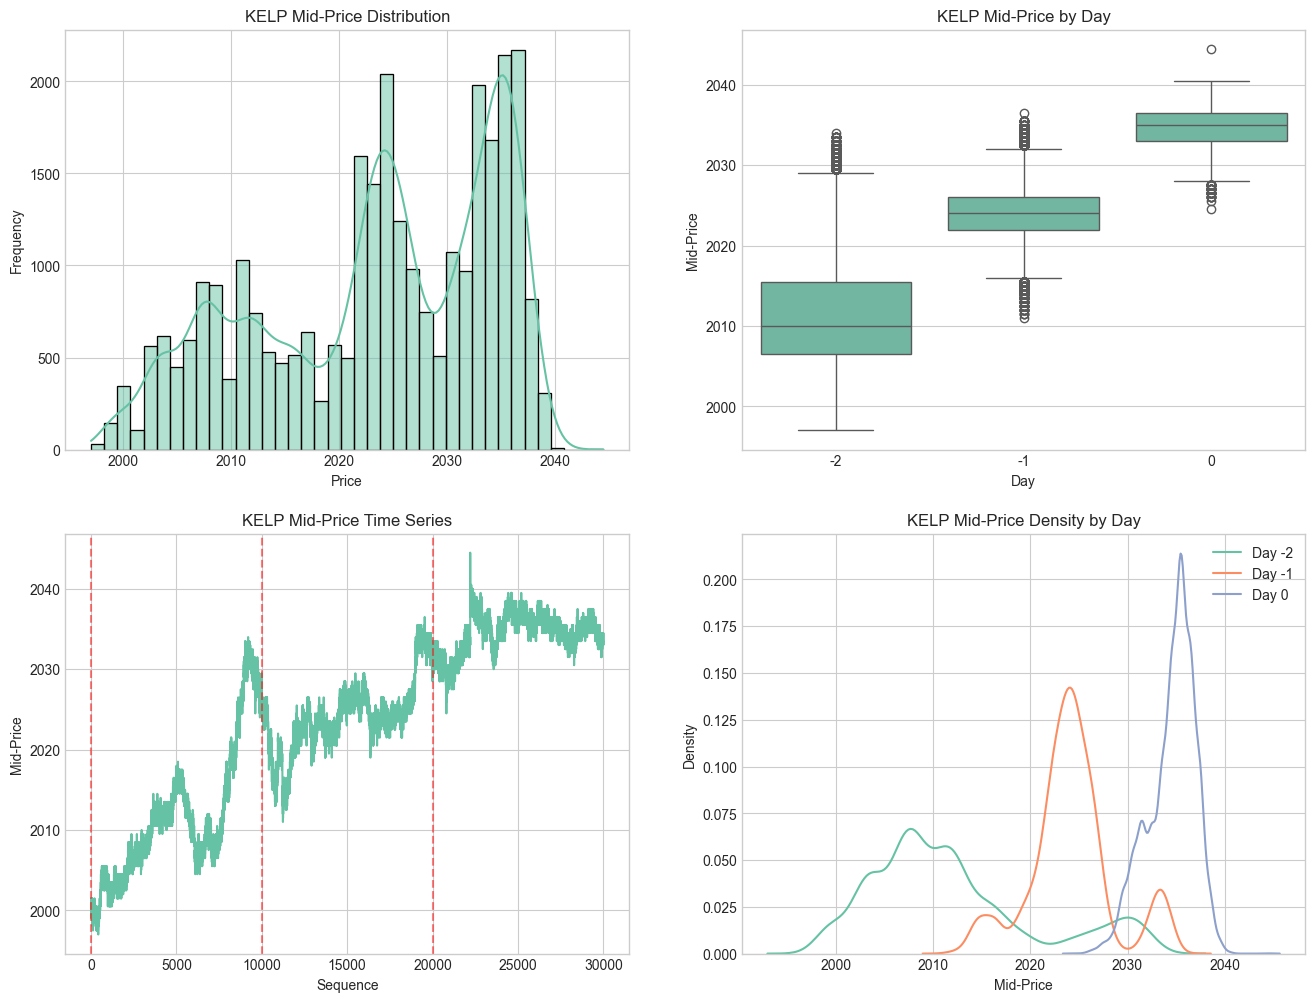

In [34]:
## 3. Visualizing Price Distribution and Trends
# Create a figure with multiple plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Histogram of mid prices
sns.histplot(kelp_data['mid_price'], ax=axs[0, 0] , kde=True, line_kws={'color': 'red'})
axs[0, 0].set_title('KELP Mid-Price Distribution')
axs[0, 0].set_xlabel('Price')
axs[0, 0].set_ylabel('Frequency')

# Plot 2: Box plot by day
sns.boxplot(x='day', y='mid_price', data=kelp_data, ax=axs[0, 1])
axs[0, 1].set_title('KELP Mid-Price by Day')
axs[0, 1].set_xlabel('Day')
axs[0, 1].set_ylabel('Mid-Price')
 
# Plot 3: Time series of mid prices
# First convert timestamp to a proper time index if it exists
if 'timestamp' in kelp_data.columns:
    # Sort by timestamp within each day
    kelp_data = kelp_data.sort_values(['day', 'timestamp'])
    # Create a sequential index for plotting
    kelp_data['sequence'] = range(len(kelp_data))
    
    # Plot time series with day transitions marked
    axs[1, 0].plot(kelp_data['sequence'], kelp_data['mid_price'])
    
    # Mark day transitions with vertical lines
    day_changes = kelp_data[kelp_data['day'].diff() != 0]['sequence']
    for day_change in day_changes:
        axs[1, 0].axvline(x=day_change, color='r', linestyle='--', alpha=0.5)
    
    axs[1, 0].set_title('KELP Mid-Price Time Series')
    axs[1, 0].set_xlabel('Sequence')
    axs[1, 0].set_ylabel('Mid-Price')
else:
    axs[1, 0].text(0.5, 0.5, 'Timestamp data not available', 
                  horizontalalignment='center', verticalalignment='center')

# Plot 4: Density plot by day
for day in kelp_data['day'].unique():
    day_data = kelp_data[kelp_data['day'] == day]['mid_price']
    sns.kdeplot(day_data, label=f'Day {day}', ax=axs[1, 1])
    
axs[1, 1].set_title('KELP Mid-Price Density by Day')
axs[1, 1].set_xlabel('Mid-Price')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

# plt.tight_layout()
plt.show()

In [35]:
# 4. Bid-Ask Spread Analysis
# Calculate bid-ask spread
kelp_data['spread'] = kelp_data['ask_price_1'] - kelp_data['bid_price_1']
kelp_data['relative_spread'] = kelp_data['spread'] / kelp_data['mid_price'] * 100

# Basic spread statistics
spread_stats = kelp_data[['spread', 'relative_spread']].describe()
print("Bid-Ask Spread Statistics:")
print(spread_stats)


Bid-Ask Spread Statistics:
             spread  relative_spread
count  30000.000000     30000.000000
mean       2.712200         0.134035
std        0.881474         0.043549
min        1.000000         0.049008
25%        2.000000         0.098912
50%        3.000000         0.147747
75%        3.000000         0.149217
max        4.000000         0.200200


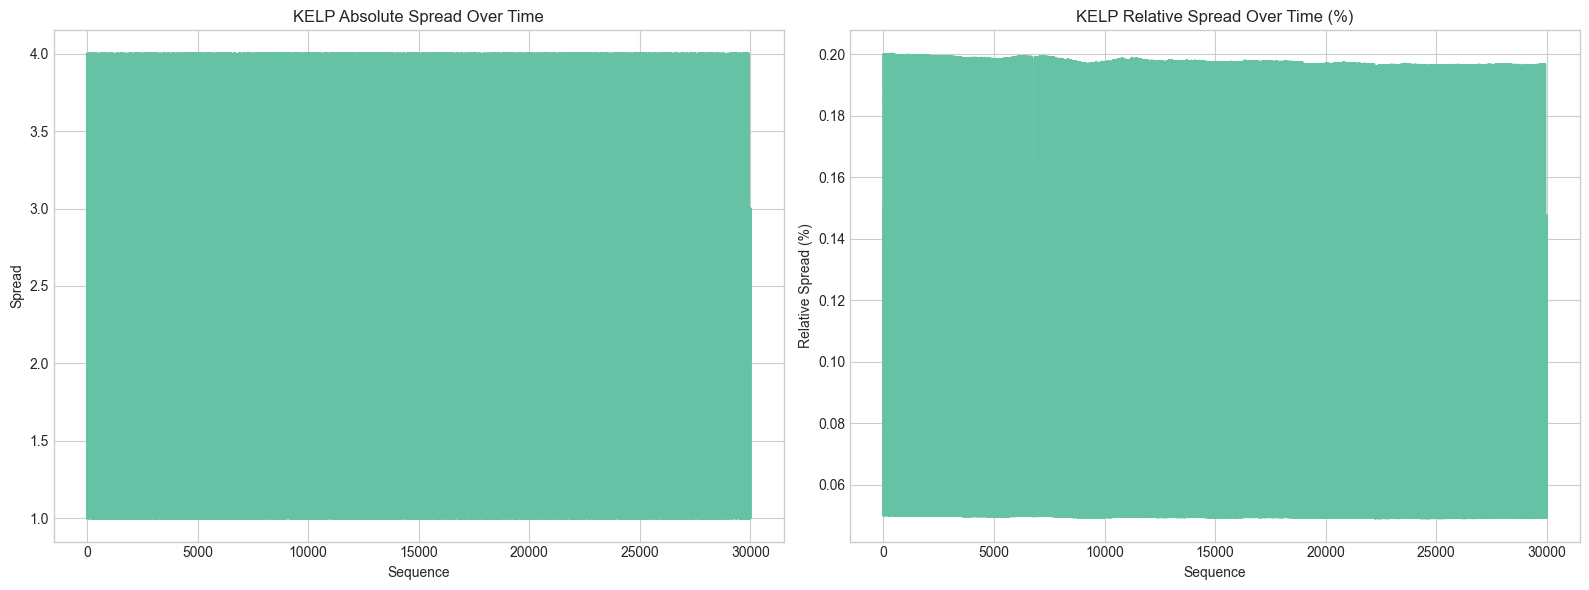

In [36]:
# Visualize spreads
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot absolute spread over time
axs[0].plot(kelp_data['sequence'] if 'sequence' in kelp_data.columns else range(len(kelp_data)), 
           kelp_data['spread'])
axs[0].set_title('KELP Absolute Spread Over Time')
axs[0].set_xlabel('Sequence')
axs[0].set_ylabel('Spread')

# Plot relative spread over time
axs[1].plot(kelp_data['sequence'] if 'sequence' in kelp_data.columns else range(len(kelp_data)), 
           kelp_data['relative_spread'])
axs[1].set_title('KELP Relative Spread Over Time (%)')
axs[1].set_xlabel('Sequence')
axs[1].set_ylabel('Relative Spread (%)')

plt.tight_layout()
plt.show()

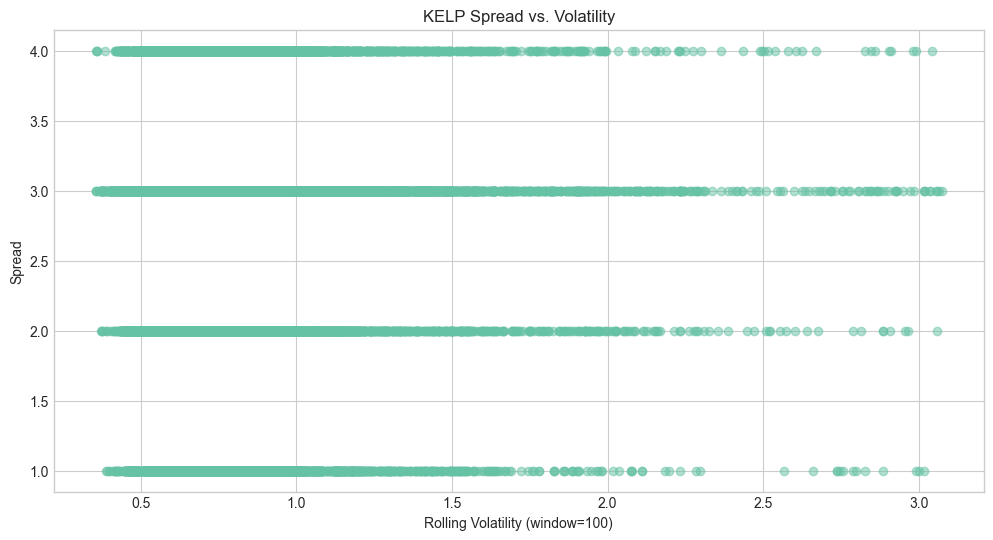

Correlation between volatility and spread: -0.0052


In [44]:
# Analyze relationship between spread and volatility
# Calculate rolling standard deviation as a volatility measure
window_size = 100  # Adjust as needed
kelp_data['rolling_volatility'] = kelp_data['mid_price'].rolling(window=window_size).std()

# Plot spread vs volatility
plt.figure(figsize=(12, 6))
plt.scatter(kelp_data['rolling_volatility'], kelp_data['spread'], alpha=0.5)
plt.title('KELP Spread vs. Volatility')
plt.xlabel('Rolling Volatility (window=' + str(window_size) + ')')
plt.ylabel('Spread')
plt.grid(True)
plt.show()

# Calculate correlation
corr = kelp_data['rolling_volatility'].corr(kelp_data['spread'])
print(f"Correlation between volatility and spread: {corr:.4f}")

In [38]:
## 5. Market Depth Analysis
# Analyze market depth on both sides
kelp_data['bid_volume_total'] = kelp_data['bid_volume_1'] + kelp_data['bid_volume_2'] + kelp_data['bid_volume_3']
kelp_data['ask_volume_total'] = kelp_data['ask_volume_1'] + kelp_data['ask_volume_2'] + kelp_data['ask_volume_3']
kelp_data['volume_imbalance'] = kelp_data['bid_volume_total'] - kelp_data['ask_volume_total']
kelp_data['relative_imbalance'] = kelp_data['volume_imbalance'] / (kelp_data['bid_volume_total'] + kelp_data['ask_volume_total'])

# Market depth statistics
depth_stats = kelp_data[['bid_volume_total', 'ask_volume_total', 'volume_imbalance', 'relative_imbalance']].describe()
print("Market Depth Statistics:")
print(depth_stats)


Market Depth Statistics:
       bid_volume_total  ask_volume_total  volume_imbalance  \
count        496.000000        663.000000               0.0   
mean          31.060484         31.242836               NaN   
std            5.459157          5.561508               NaN   
min            6.000000          6.000000               NaN   
25%           28.000000         28.000000               NaN   
50%           31.000000         32.000000               NaN   
75%           34.000000         35.000000               NaN   
max           45.000000         43.000000               NaN   

       relative_imbalance  
count                 0.0  
mean                  NaN  
std                   NaN  
min                   NaN  
25%                   NaN  
50%                   NaN  
75%                   NaN  
max                   NaN  


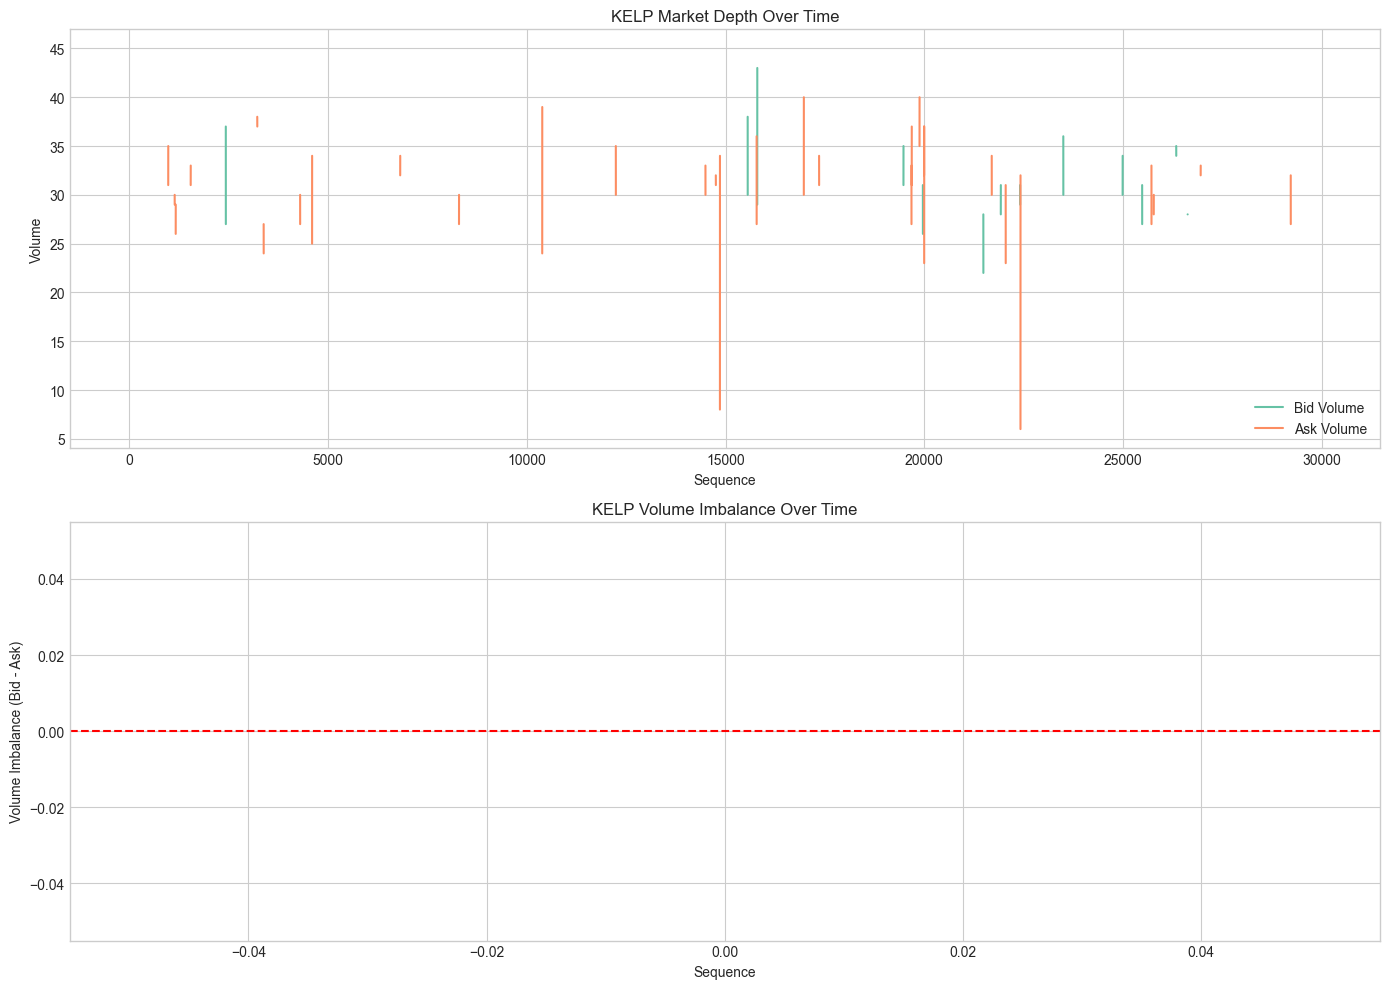

In [39]:
# Visualize market depth and imbalance
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Plot total volumes over time
axs[0].plot(kelp_data['sequence'] if 'sequence' in kelp_data.columns else range(len(kelp_data)), 
           kelp_data['bid_volume_total'], label='Bid Volume')
axs[0].plot(kelp_data['sequence'] if 'sequence' in kelp_data.columns else range(len(kelp_data)), 
           kelp_data['ask_volume_total'], label='Ask Volume')
axs[0].set_title('KELP Market Depth Over Time')
axs[0].set_xlabel('Sequence')
axs[0].set_ylabel('Volume')
axs[0].legend()

# Plot volume imbalance over time
axs[1].plot(kelp_data['sequence'] if 'sequence' in kelp_data.columns else range(len(kelp_data)), 
           kelp_data['volume_imbalance'])
axs[1].set_title('KELP Volume Imbalance Over Time')
axs[1].set_xlabel('Sequence')
axs[1].set_ylabel('Volume Imbalance (Bid - Ask)')
axs[1].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()


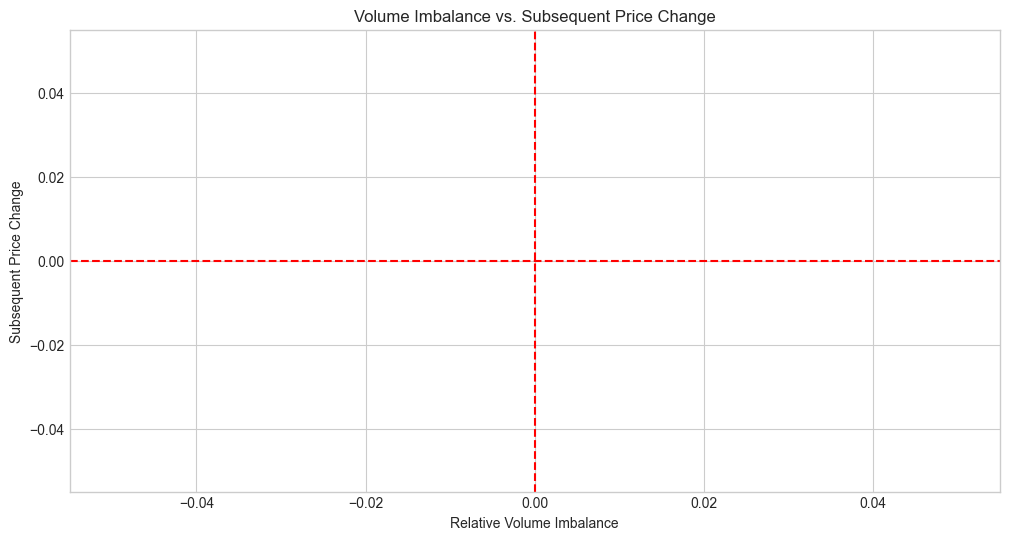

Correlation between volume imbalance and subsequent price change: nan


In [40]:
# Analyze relationship between volume imbalance and subsequent price moves
# Calculate price changes
kelp_data['price_change'] = kelp_data['mid_price'].diff().shift(-1)  # Next period's price change

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(kelp_data['relative_imbalance'], kelp_data['price_change'], alpha=0.5)
plt.title('Volume Imbalance vs. Subsequent Price Change')
plt.xlabel('Relative Volume Imbalance')
plt.ylabel('Subsequent Price Change')
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Calculate correlation
imbalance_price_corr = kelp_data['relative_imbalance'].corr(kelp_data['price_change'])
print(f"Correlation between volume imbalance and subsequent price change: {imbalance_price_corr:.4f}")

In [45]:
## 6. Price Movement Analysis

# Calculate various price change metrics
kelp_data['price_change'] = kelp_data['mid_price'].diff()
kelp_data['pct_change'] = kelp_data['mid_price'].pct_change() * 100
kelp_data['direction'] = np.sign(kelp_data['price_change'])

# Calculate moving averages
kelp_data['ma_5'] = kelp_data['mid_price'].rolling(window=5).mean()
kelp_data['ma_20'] = kelp_data['mid_price'].rolling(window=20).mean()

# Price change statistics
change_stats = kelp_data[['price_change', 'pct_change']].describe()
print("Price Change Statistics:")
print(change_stats)

# Count directional movements
direction_counts = kelp_data['direction'].value_counts()
print("\nDirectional Movement Counts:")
print(direction_counts)
print(f"Up/Down Ratio: {direction_counts.get(1.0, 0) / direction_counts.get(-1.0, 1):.4f}")


Price Change Statistics:
       price_change    pct_change
count  29999.000000  29999.000000
mean       0.001117      0.000063
std        0.781493      0.038624
min       -4.000000     -0.195647
25%       -0.500000     -0.024618
50%        0.000000      0.000000
75%        0.500000      0.024631
max       11.500000      0.565667

Directional Movement Counts:
direction
 0.0    11714
 1.0     9148
-1.0     9137
Name: count, dtype: int64
Up/Down Ratio: 1.0012


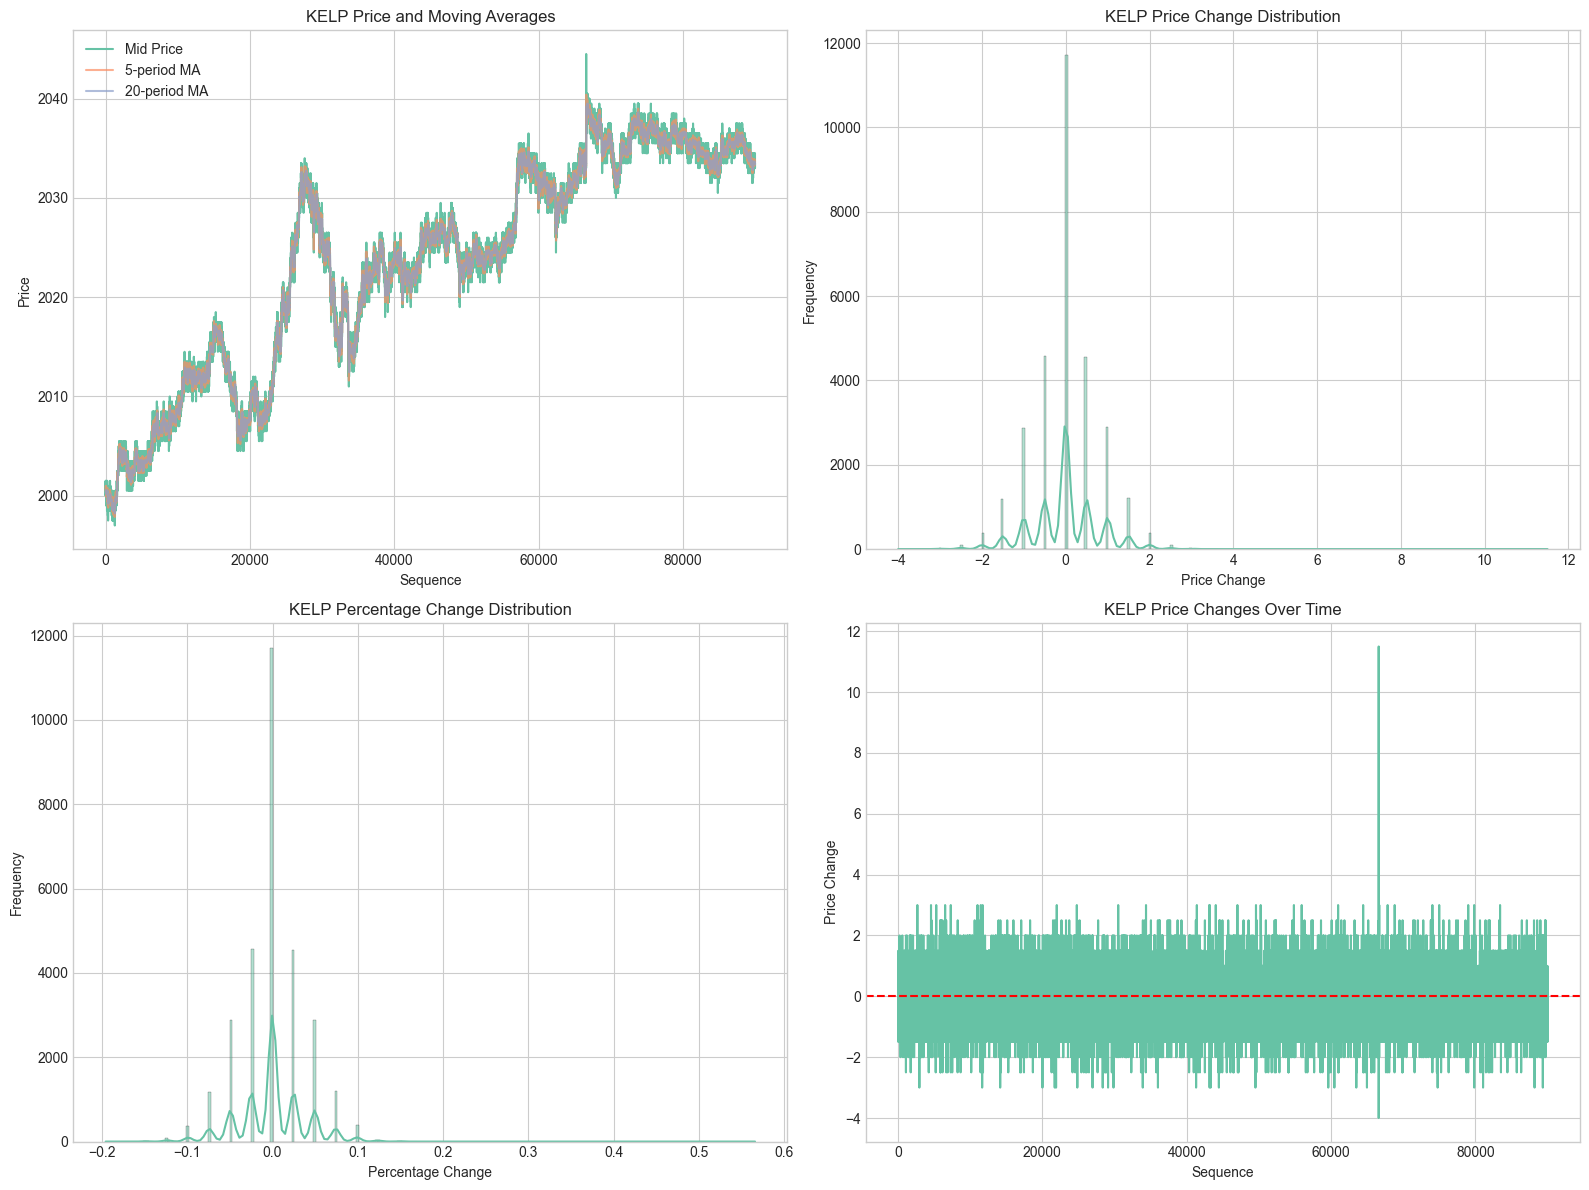

In [46]:
# Visualize price changes
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Price with moving averages
axs[0, 0].plot(kelp_data['mid_price'], label='Mid Price')
axs[0, 0].plot(kelp_data['ma_5'], label='5-period MA', alpha=0.7)
axs[0, 0].plot(kelp_data['ma_20'], label='20-period MA', alpha=0.7)
axs[0, 0].set_title('KELP Price and Moving Averages')
axs[0, 0].set_xlabel('Sequence')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# Plot 2: Histogram of price changes
sns.histplot(kelp_data['price_change'].dropna(), kde=True, ax=axs[0, 1])
axs[0, 1].set_title('KELP Price Change Distribution')
axs[0, 1].set_xlabel('Price Change')
axs[0, 1].set_ylabel('Frequency')

# Plot 3: Histogram of percentage changes
sns.histplot(kelp_data['pct_change'].dropna(), kde=True, ax=axs[1, 0])
axs[1, 0].set_title('KELP Percentage Change Distribution')
axs[1, 0].set_xlabel('Percentage Change')
axs[1, 0].set_ylabel('Frequency')

# Plot 4: Price changes over time
axs[1, 1].plot(kelp_data['price_change'])
axs[1, 1].set_title('KELP Price Changes Over Time')
axs[1, 1].set_xlabel('Sequence')
axs[1, 1].set_ylabel('Price Change')
axs[1, 1].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [47]:
## 7. Mean Reversion Analysis
# Calculate z-scores based on rolling statistics
window_size = 20  # Adjust as needed
kelp_data['rolling_mean'] = kelp_data['mid_price'].rolling(window=window_size).mean()
kelp_data['rolling_std'] = kelp_data['mid_price'].rolling(window=window_size).std()
kelp_data['z_score'] = (kelp_data['mid_price'] - kelp_data['rolling_mean']) / kelp_data['rolling_std']

# Print z-score statistics
z_score_stats = kelp_data['z_score'].describe()
print("Z-Score Statistics:")
print(z_score_stats)

Z-Score Statistics:
count    29981.000000
mean         0.010993
std          1.058843
min         -3.879796
25%         -0.629153
50%          0.000000
75%          0.638077
max          4.216451
Name: z_score, dtype: float64


ADF Test Results:
Test Statistic: -1.9935
p-value: 0.2895
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is non-stationary (not mean-reverting)

Lag-1 Autocorrelation: 0.9974
The positive autocorrelation suggests trending behavior


<Figure size 1200x600 with 0 Axes>

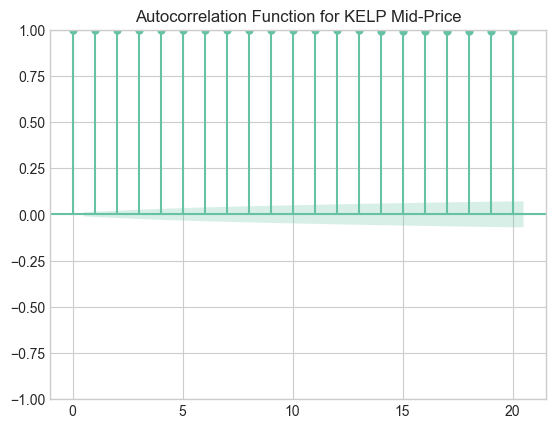

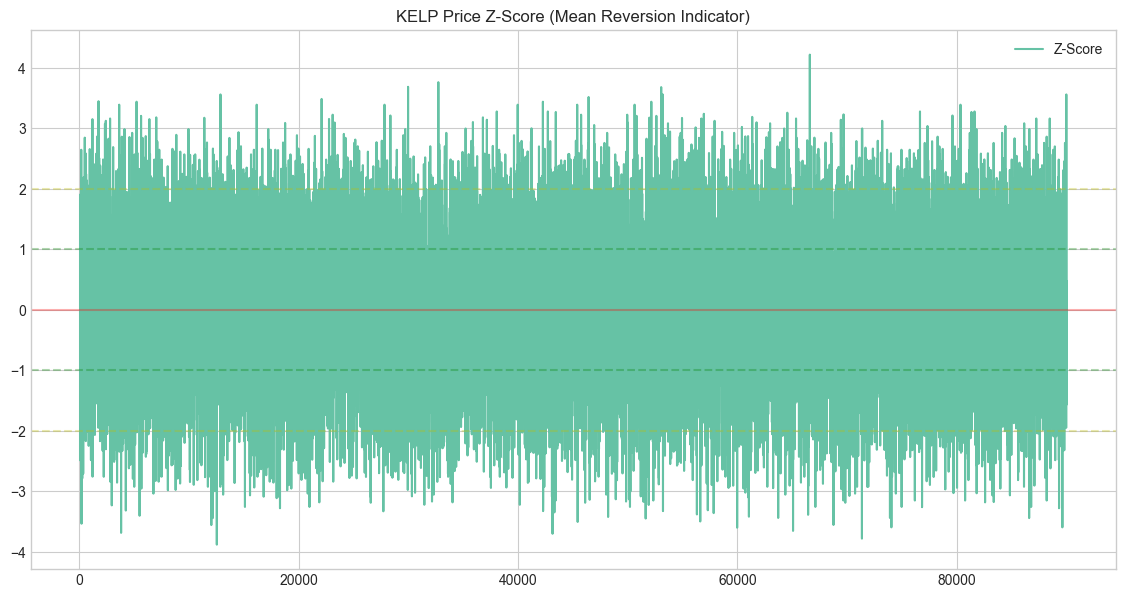

In [49]:

# Test for mean reversion - Augmented Dickey-Fuller test
def test_stationarity(series):
    """Perform ADF test to check for stationarity/mean reversion"""
    result = adfuller(series.dropna())
    
    print('ADF Test Results:')
    print(f'Test Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    if result[1] < 0.05:
        print("Conclusion: The series is stationary (mean-reverting)")
    else:
        print("Conclusion: The series is non-stationary (not mean-reverting)")
    
    return result

# Run ADF test on mid prices
adf_result = test_stationarity(kelp_data['mid_price'])

# Calculate autocorrelation to measure mean reversion strength
lag_1_autocorr = kelp_data['mid_price'].autocorr(lag=1)
print(f"\nLag-1 Autocorrelation: {lag_1_autocorr:.4f}")

# A negative autocorrelation indicates mean reversion tendency
if lag_1_autocorr < 0:
    print("The negative autocorrelation suggests mean-reverting behavior")
else:
    print("The positive autocorrelation suggests trending behavior")

# Plot autocorrelation function
plt.figure(figsize=(12, 6))
plot_acf(kelp_data['mid_price'].dropna(), lags=20)
plt.title('Autocorrelation Function for KELP Mid-Price')
plt.show()

# Visualize mean reversion with z-scores
plt.figure(figsize=(14, 7))
plt.plot(kelp_data['z_score'], label='Z-Score')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='g', linestyle='--', alpha=0.3)
plt.axhline(y=-1, color='g', linestyle='--', alpha=0.3)
plt.axhline(y=2, color='y', linestyle='--', alpha=0.3)
plt.axhline(y=-2, color='y', linestyle='--', alpha=0.3)
plt.title('KELP Price Z-Score (Mean Reversion Indicator)')
plt.legend()
plt.grid(True)
plt.show()


In [50]:

# Calculate half-life of mean reversion
# This estimates how long it takes for price to revert halfway to its mean
def calculate_half_life(price):
    """Calculate half-life of mean reversion"""
    price_lag = price.shift(1)
    delta = price - price_lag
    
    # Avoid NaN values
    price_lag = price_lag.dropna()
    delta = delta.dropna()
    
    # Ensure equal length
    if len(price_lag) > len(delta):
        price_lag = price_lag[-len(delta):]
    else:
        delta = delta[-len(price_lag):]
        
    # Linear regression of price changes against lagged price levels
    model = np.polyfit(price_lag, delta, 1)
    slope = model[0]
    
    # Calculate half-life
    if slope < 0:  # Only meaningful for mean-reverting series
        half_life = -np.log(2) / slope
        return half_life
    else:
        return None

half_life = calculate_half_life(kelp_data['mid_price'])
if half_life:
    print(f"Half-life of mean reversion: {half_life:.2f} periods")
else:
    print("Series does not exhibit mean reversion based on half-life calculation")


Half-life of mean reversion: 263.12 periods


In [51]:
# 8. Volatility Analysis

# Calculate different volatility measures
# 1. Simple rolling standard deviation
kelp_data['rolling_vol_20'] = kelp_data['pct_change'].rolling(window=20).std()

# 2. Exponentially weighted moving average (EWMA) volatility
kelp_data['ewma_vol'] = kelp_data['pct_change'].ewm(span=20).std()

# 3. High-Low range-based volatility (Parkinson volatility)
kelp_data['hl_range'] = (kelp_data['ask_price_1'] - kelp_data['bid_price_1']) / kelp_data['mid_price']
kelp_data['parkinson_vol'] = np.sqrt((1 / (4 * np.log(2))) * kelp_data['hl_range'].rolling(window=20).var())

# Volatility statistics
vol_stats = kelp_data[['rolling_vol_20', 'ewma_vol', 'parkinson_vol']].describe()
print("Volatility Statistics (in percentage points):")
print(vol_stats)

Volatility Statistics (in percentage points):
       rolling_vol_20      ewma_vol  parkinson_vol
count    29980.000000  29998.000000   29981.000000
mean         0.038146      0.038218       0.000256
std          0.010396      0.009961       0.000047
min          0.008062      0.012418       0.000067
25%          0.030928      0.031286       0.000225
50%          0.037641      0.037371       0.000259
75%          0.044737      0.044196       0.000287
max          0.144274      0.181046       0.000406


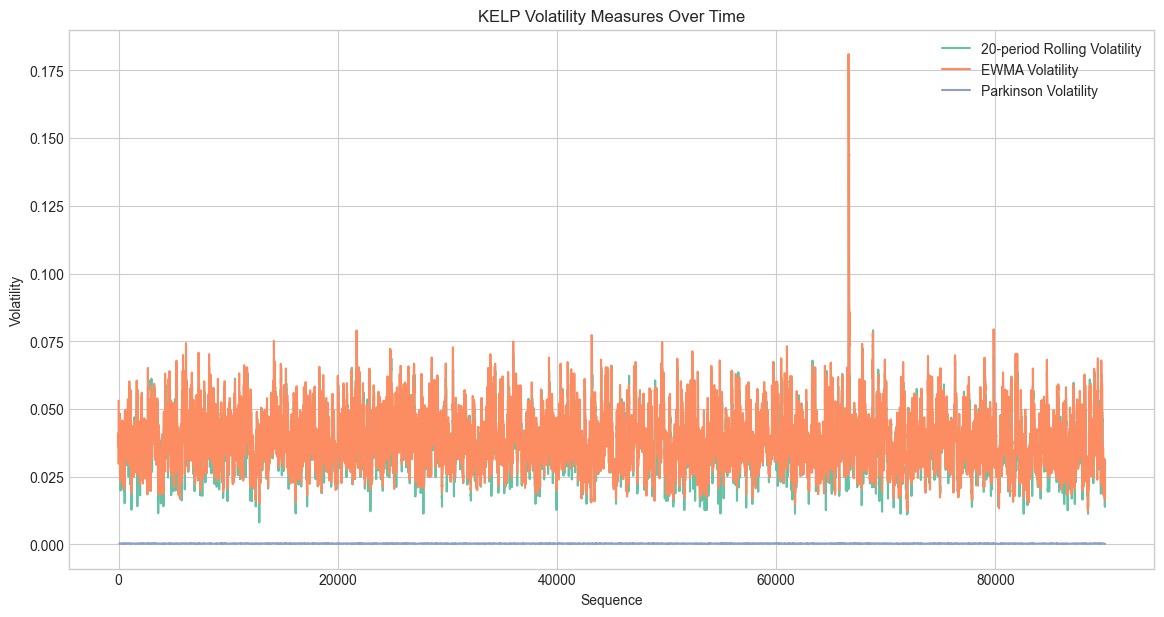

Volatility autocorrelation (lag 1): 0.9712
Evidence of volatility clustering: high volatility tends to be followed by high volatility


In [54]:
# Visualize volatility measures
plt.figure(figsize=(14, 7))
plt.plot(kelp_data['rolling_vol_20'], label='20-period Rolling Volatility')
plt.plot(kelp_data['ewma_vol'], label='EWMA Volatility')
plt.plot(kelp_data['parkinson_vol'], label='Parkinson Volatility')
plt.title('KELP Volatility Measures Over Time')
plt.xlabel('Sequence')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Checking if volatility is clustered (common in financial markets)
vol_autocorr = kelp_data['rolling_vol_20'].autocorr(lag=1)
print(f"Volatility autocorrelation (lag 1): {vol_autocorr:.4f}")
if vol_autocorr > 0.3:
    print("Evidence of volatility clustering: high volatility tends to be followed by high volatility")


Available symbols in the trades data: ['KELP' 'RAINFOREST_RESIN' 'SQUID_INK']
Found 8804 trades for symbol 'KELP'


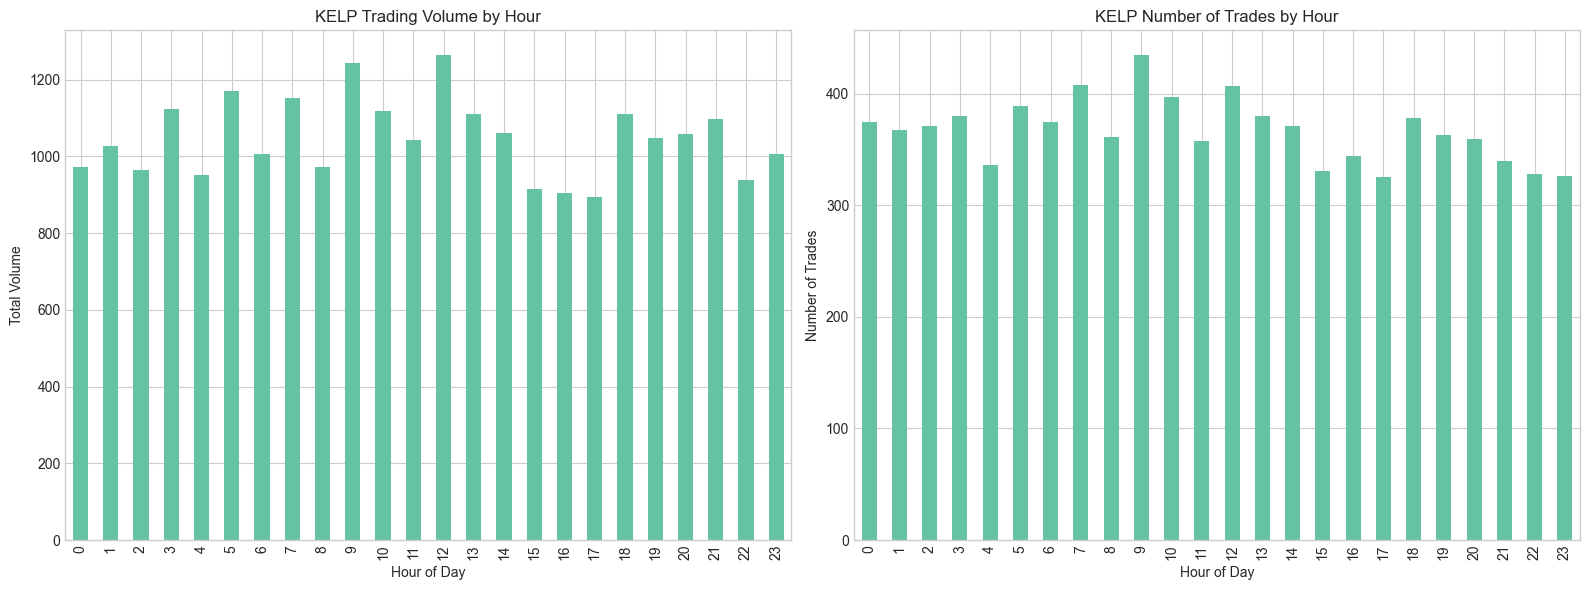

Trading Volume Statistics by Hour:
count      24.000000
mean     1047.833333
std       101.670254
min       893.000000
25%       971.000000
50%      1046.000000
75%      1112.500000
max      1265.000000
Name: quantity, dtype: float64


In [61]:
## 9. Trading Volume Analysis from Trades Data

# Analyze trading volume from trades data
# Combine trades data
trades_combined = pd.concat([
    trades_day_0.assign(day=0),
    trades_day_1.assign(day=1),
    trades_day_2.assign(day=2)
], ignore_index=True)

# Check what symbols are available in the dataset
available_symbols = trades_combined["symbol"].unique()
print(f"Available symbols in the trades data: {available_symbols}")

# Try filtering for KELP trades (or PEARLS if that's what's in the data)
symbol_to_use = "KELP" if "KELP" in available_symbols else "PEARLS"
kelp_trades = trades_combined[trades_combined["symbol"] == symbol_to_use].copy()

print(f"Found {len(kelp_trades)} trades for symbol '{symbol_to_use}'")

# Only proceed with plotting if we have data
if len(kelp_trades) > 0 and 'timestamp' in kelp_trades.columns:
    # Convert timestamp to hour of day if available
    kelp_trades['hour'] = (kelp_trades['timestamp'] % 86400) // 3600
    
    # Analyze trading volume by hour
    volume_by_hour = kelp_trades.groupby('hour')['quantity'].sum()
    trades_by_hour = kelp_trades.groupby('hour').size()
    
    # Only create plots if there's data
    if len(volume_by_hour) > 0:
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot volume by hour
        volume_by_hour.plot(kind='bar', ax=axs[0])
        axs[0].set_title(f'{symbol_to_use} Trading Volume by Hour')
        axs[0].set_xlabel('Hour of Day')
        axs[0].set_ylabel('Total Volume')
        
        # Plot number of trades by hour
        trades_by_hour.plot(kind='bar', ax=axs[1])
        axs[1].set_title(f'{symbol_to_use} Number of Trades by Hour')
        axs[1].set_xlabel('Hour of Day')
        axs[1].set_ylabel('Number of Trades')
        
        plt.tight_layout()
        plt.show()
        
        print("Trading Volume Statistics by Hour:")
        print(volume_by_hour.describe())
    else:
        print("No hourly trading data available to plot")
else:
    # If we're missing expected columns, check what columns we do have
    if len(kelp_trades) > 0:
        print(f"Available columns in the trades data: {kelp_trades.columns.tolist()}")
        
        # Try to analyze with whatever quantity column might be available
        quantity_cols = [col for col in kelp_trades.columns if 'quant' in col.lower()]
        if quantity_cols:
            print(f"Found potential quantity columns: {quantity_cols}")
            print("Sample of the first few trades:")
            print(kelp_trades[quantity_cols + ['timestamp']].head())
        else:
            print("Sample of the first few trades to help identify the structure:")
            print(kelp_trades.head())
    else:
        print("No trades data found matching the criteria")

ARIMA(1,0,0) - RMSE: nan, MAE: nan
ARIMA(1,0,1) - RMSE: nan, MAE: nan
ARIMA(1,1,0) - RMSE: nan, MAE: nan
ARIMA(1,1,1) - RMSE: nan, MAE: nan
ARIMA(2,0,0) - RMSE: nan, MAE: nan
ARIMA(2,0,1) - RMSE: nan, MAE: nan
ARIMA(2,1,0) - RMSE: nan, MAE: nan
ARIMA(2,1,1) - RMSE: nan, MAE: nan

Best model: ARIMA(1,0,0) with RMSE: nan


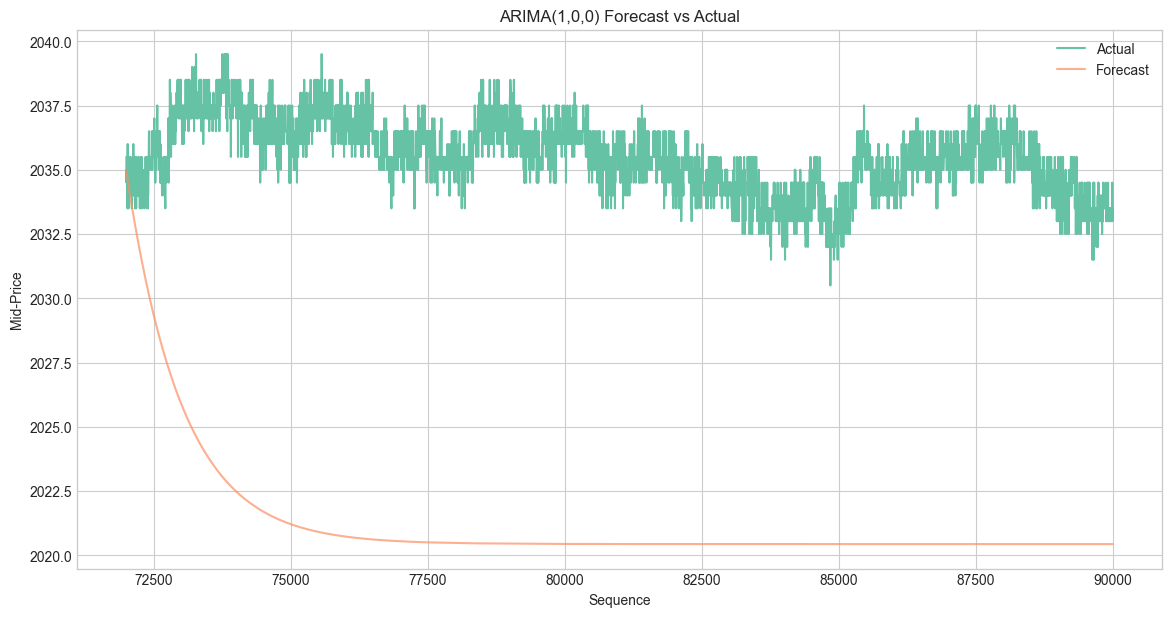

In [57]:
## 10. Predictive Modeling with ARIMA

# Prepare data for ARIMA model
# Use a portion of the data for training
train_size = int(len(kelp_data) * 0.8)
train_data = kelp_data['mid_price'][:train_size]
test_data = kelp_data['mid_price'][train_size:]

# Function to evaluate ARIMA models
def evaluate_arima_model(p, d, q):
    """Evaluate an ARIMA model with given parameters"""
    try:
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast on test set
        forecast = model_fit.forecast(steps=len(test_data))
        
        # Calculate error metrics
        mse = ((forecast - test_data) ** 2).mean()
        rmse = np.sqrt(mse)
        mae = abs(forecast - test_data).mean()
        
        return {'p': p, 'd': d, 'q': q, 'mse': mse, 'rmse': rmse, 'mae': mae, 'model': model_fit, 'forecast': forecast}
    except Exception as e:
        print(f"Error with ARIMA({p},{d},{q}): {e}")
        return None

# Test a few ARIMA models
models = []
for p in [1, 2]:
    for d in [0, 1]:
        for q in [0, 1]:
            result = evaluate_arima_model(p, d, q)
            if result:
                models.append(result)
                print(f"ARIMA({p},{d},{q}) - RMSE: {result['rmse']:.4f}, MAE: {result['mae']:.4f}")

# Find best model
if models:
    best_model = min(models, key=lambda x: x['rmse'])
    print(f"\nBest model: ARIMA({best_model['p']},{best_model['d']},{best_model['q']}) with RMSE: {best_model['rmse']:.4f}")
    
    # Plot actual vs forecast
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data.values, label='Actual')
    plt.plot(test_data.index, best_model['forecast'], label='Forecast', alpha=0.7)
    plt.title(f"ARIMA({best_model['p']},{best_model['d']},{best_model['q']}) Forecast vs Actual")
    plt.xlabel('Sequence')
    plt.ylabel('Mid-Price')
    plt.legend()
    plt.grid(True)
    plt.show()

Z-Score Threshold: 0.5
  total_market_return: 0.0167
  total_strategy_return: 55.1864
  outperformance: 55.1697
  sharpe_ratio: 1.2669
  win_rate: 0.5720
  total_trades: 17335

Z-Score Threshold: 1.0
  total_market_return: 0.0167
  total_strategy_return: 25.4279
  outperformance: 25.4111
  sharpe_ratio: 1.1803
  win_rate: 0.6964
  total_trades: 9899

Z-Score Threshold: 1.5
  total_market_return: 0.0167
  total_strategy_return: 7.8941
  outperformance: 7.8774
  sharpe_ratio: 0.9528
  win_rate: 0.8018
  total_trades: 4975

Z-Score Threshold: 2.0
  total_market_return: 0.0167
  total_strategy_return: 1.9721
  outperformance: 1.9554
  sharpe_ratio: 0.6486
  win_rate: 0.8667
  total_trades: 2093



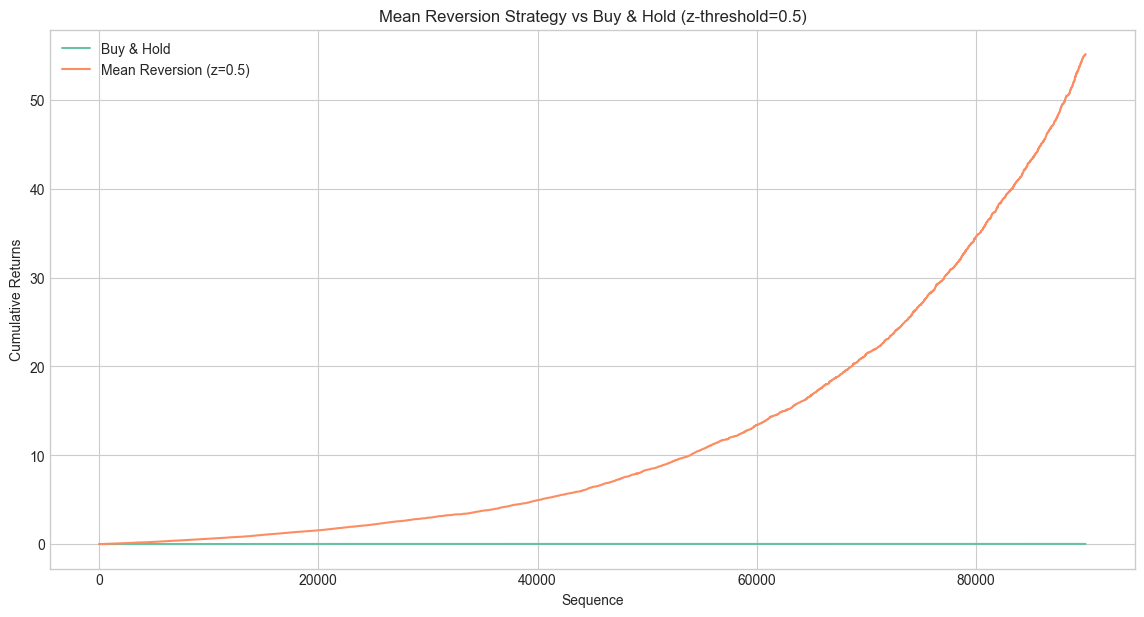

In [59]:
# 11. Simulating Trading Strategies

# Simple Mean Reversion Trading Strategy Backtesting
def backtest_mean_reversion(data, z_threshold=1.0):
    """Backtest a simple mean reversion strategy"""
    # Create a copy to avoid modifying original data
    backtest = data.copy()
    
    # Generate trading signals
    backtest['signal'] = 0
    backtest.loc[backtest['z_score'] <= -z_threshold, 'signal'] = 1  # Buy signal
    backtest.loc[backtest['z_score'] >= z_threshold, 'signal'] = -1  # Sell signal
    
    # Calculate returns
    backtest['returns'] = backtest['mid_price'].pct_change()
    
    # Strategy returns (position * subsequent return)
    backtest['strategy_returns'] = backtest['signal'].shift(1) * backtest['returns']
    
    # Cumulative returns
    backtest['cumulative_market_returns'] = (1 + backtest['returns']).cumprod() - 1
    backtest['cumulative_strategy_returns'] = (1 + backtest['strategy_returns']).cumprod() - 1
    
    # Performance metrics
    total_market_return = backtest['cumulative_market_returns'].iloc[-1]
    total_strategy_return = backtest['cumulative_strategy_returns'].iloc[-1]
    
    sharpe_ratio = (backtest['strategy_returns'].mean() / backtest['strategy_returns'].std() * 
                    np.sqrt(252 * 1000 / len(backtest)))  # Assuming 1000 trades per day
    
    # Calculate win rate
    winning_trades = (backtest['strategy_returns'] > 0).sum()
    total_trades = (backtest['signal'] != 0).sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    metrics = {
        'total_market_return': total_market_return,
        'total_strategy_return': total_strategy_return,
        'outperformance': total_strategy_return - total_market_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate,
        'total_trades': total_trades
    }
    
    return metrics, backtest

# Backtest with different z-score thresholds
thresholds = [0.5, 1.0, 1.5, 2.0]
results = []

for threshold in thresholds:
    metrics, backtest_data = backtest_mean_reversion(kelp_data, threshold)
    results.append({
        'threshold': threshold,
        **metrics
    })
    print(f"Z-Score Threshold: {threshold}")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")
    print()

# Plot strategy performance for best threshold
best_threshold = max(results, key=lambda x: x['sharpe_ratio'])['threshold']
_, best_backtest = backtest_mean_reversion(kelp_data, best_threshold)

plt.figure(figsize=(14, 7))
plt.plot(best_backtest['cumulative_market_returns'], label='Buy & Hold')
plt.plot(best_backtest['cumulative_strategy_returns'], label=f'Mean Reversion (z={best_threshold})')
plt.title(f'Mean Reversion Strategy vs Buy & Hold (z-threshold={best_threshold})')
plt.xlabel('Sequence')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# 12. Conclusion and Trading Strategy Recommendations

# Summarize findings
print("# Summary of KELP Mid-Price Analysis")
print("\n## Key Statistics")
print(f"Average Mid-Price: {kelp_data['mid_price'].mean():.4f}")
print(f"Average Spread: {kelp_data['spread'].mean():.4f} ({kelp_data['relative_spread'].mean():.4f}%)")
print(f"Average Daily Volatility: {kelp_data.groupby('day')['mid_price'].std().mean():.4f}")

print("\n## Price Behavior Assessment")
if adf_result[1] < 0.05 and lag_1_autocorr < 0:
    print("KELP exhibits strong mean-reverting behavior")
elif adf_result[1] < 0.05:
    print("KELP is stationary but doesn't show strong mean-reversion")
else:
    print("KELP does not exhibit stationary behavior")

print("\n## Recommended Trading Approach")
# Base recommendation on analysis results
if adf_result[1] < 0.05 and lag_1_autocorr < 0:
    print("Implement a mean-reversion strategy:")
    print(f"- Buy when z-score below {best_threshold}")
    print(f"- Sell when z-score above {best_threshold}")
    print(f"- Expected win rate: {best_backtest['win_rate'].mean():.1%}")
elif vol_autocorr > 0.3:
    print("Implement a volatility-based market making strategy:")
    print("- Widen spreads during high volatility periods")

# Summary of KELP Mid-Price Analysis

## Key Statistics
Average Mid-Price: 2023.4765
Average Spread: 2.7122 (0.1340%)
Average Daily Volatility: 5.0669

## Price Behavior Assessment
KELP does not exhibit stationary behavior

## Recommended Trading Approach
Implement a volatility-based market making strategy:
- Widen spreads during high volatility periods
